# Mutual Information-based Registration

## Introduction
In this exercise, you will implement 3D rigid image registration using mutual information (MI). You will work with a T1-weighted and a T2-weighted MRI scan of the same patient, where the patient is lying in a different position in the scanner between the two image acquisition (for the purpose of this exercise, the movement is simulated).

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.



### Introduction

This exercise examines the use of **mutual information (MI)** to perform automated registration between T1-weighted and T2-weighted MRI images, accommodating the differing intensity profiles these imaging types often present. Mutual information optimization allows for effective anatomical alignment despite the variations in imaging intensity, by maximizing the frequency of co-occurring intensity pairs across images.

To begin, we preprocess the fixed (T1) and moving (T2) images by reducing them to $ B $ discrete intensity levels, allowing for analysis of shared intensities through a **joint histogram** $ H $, defined as:

$$
H = \begin{pmatrix}
h_{1,1} & \cdots & h_{1,B} \\
\vdots & \ddots & \vdots \\
h_{B,1} & \cdots & h_{B,B} \\
\end{pmatrix}
$$

where each entry $ h_{f,m} $ represents the frequency of a specific intensity pair $(f, m)$ between the T1 and T2 images.

In **Task 3**, we compute the mutual information between the images using the formula:

$$
\text{MI} = H_{F} + H_{M} - H_{F,M}
$$

This formula quantifies shared information between the T1 and resampled T2 images, enabling us to assess image similarity.

**Task 4** extends this by evaluating MI across rotation angles using a parameterized **3D rotation matrix**, applied one axis at a time:

$$
\mathbf{R} = \mathbf{R}_{z} \, \text{or} \, \mathbf{R}_{y} \, \text{or} \, \mathbf{R}_{x}
$$

By testing various angles, we identify the optimal rotation for alignment.

In **Tasks 5 and 6**, we implement **automatic registration** by calculating the **energy function**:

$$
E(\mathbf{w}) = H_{F,M} - H_{F} - H_{M}
$$

This function is plotted across angles in a grid search, and the **joint histograms before and after registration** are compared to validate the alignment.

In summary, this mutual information-based registration method utilizes the negative of mutual information as an energy function, optimizing $ E(\mathbf{w}) $ numerically to minimize the misalignment between T1 and T2 images. Through this process, we achieve a robust, parameter-optimized alignment of MRI images.

### Input data and code hints
Import Python libraries:

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
#%matplotlib notebook
# %matplotlib tk
plt.ion()
np.set_printoptions( suppress=True )
import nibabel as nib
import scipy
from scipy.ndimage import map_coordinates

Read the two 3D scans you'll be working with in this exercise:

In [2]:
T1_fileName = 'IXI014-HH-1236-T1.nii.gz'
T2_fileName = 'IXI014-HH-1236-T2_rotated.nii.gz'
T1 = nib.load( T1_fileName )
T2 = nib.load( T2_fileName )
T1_data = T1.get_fdata()
T2_data = T2.get_fdata()

FileNotFoundError: No such file or no access: '/Users/alexandrumarin/Documents/DTU/3rd semester/Medical Image Analysis/report3/IXI014-HH-1236-IXIMADisoTFE12_-s3T113_-0301-00003-000001-01.nii'

Below is code to define a simple interactive viewer class that can be used to visualize 2D cross-sections of a 3D array along three orthogonal directions. It takes a 3D volume as input and shows the location a "linked cursor" in all three cross-sections.

The initial location of the cursor is in the middle of the volume in each case. It can be changed by clicking on one of the cross-sections. The viewer also displays the voxel index $\mathbf{v}$ of the cursor.

In [3]:
class Viewer:
    def __init__(self, data ):
        self.fig, self.ax = plt.subplots()
        self.data = data
        self.dims = self.data.shape
        self.position = np.round( np.array( self.dims ) / 2 ).astype( int )
        self.draw()
        self.fig.canvas.mpl_connect( 'button_press_event', self )
        self.fig.show()

    def __call__(self, event):
        print( 'button pressed' )
        if event.inaxes is None: return
      
        x, y = round( event.xdata ), round( event.ydata )

        #
        if ( x > (self.dims[0]-1) ) and ( y <= (self.dims[1]-1) ): return # lower-right quadrant
          
        #
        if x < self.dims[0]:
          self.position[ 0 ] = x
        else:
          self.position[ 1 ] = x - self.dims[0]
        
        if y < self.dims[1]:
          self.position[ 1 ] = y
        else:
          self.position[ 2 ] = y -self.dims[1]
        
        print( f"  voxel index: {self.position}" )
        print( f"  intensity: {self.data[ self.position[0], self.position[1], self.position[2] ]}" )

        self.draw()

    def draw( self ):
        #
        # Layout on screen is like this:
        #
        #     ^            ^
        #  Z  |         Z  |
        #     |            |
        #     ----->        ---->  
        #       X             Y
        #     ^
        #  Y  |
        #     |
        #     ----->  
        #       X
        #
        dims = self.dims
        position = self.position
        
        xySlice = self.data[ :, :, position[ 2 ] ]
        xzSlice = self.data[ :, position[ 1 ], : ]
        yzSlice = self.data[ position[ 0 ], :, : ]
        
        kwargs = dict( vmin=self.data.min(), vmax=self.data.max(), 
                       origin='lower', 
                       cmap='gray',
                       picker=True )

        self.ax.clear()

        self.ax.imshow( xySlice.T, 
                        extent=( 0, dims[0]-1, 
                                 0, dims[1]-1 ), 
                        **kwargs )
        self.ax.imshow( xzSlice.T, 
                        extent=( 0, dims[0]-1, 
                                 dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )
        self.ax.imshow( yzSlice.T, extent=( dims[0], dims[0]+dims[1]-1, 
                                            dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )

        color = 'g'
        self.ax.plot( (0, dims[0]-1), (position[1], position[1]), color )
        self.ax.plot( (0, dims[0]+dims[1]-1), (dims[1]+position[2], dims[1]+position[2]), color )
        self.ax.plot( (position[0], position[0]), (0, dims[1]+dims[2]-1), color )
        self.ax.plot( (dims[0]+position[1], dims[0]+position[1]), (dims[1]+1, dims[1]+dims[2]-1), color )

        self.ax.set( xlim=(1, dims[0]+dims[1]), ylim=(0, dims[1]+dims[2]) )

        self.ax.text( dims[0] + dims[1]/2, dims[1]/2, 
                      f"voxel index: {position}",  
                      horizontalalignment='center', verticalalignment='center' )
  
        self.ax.axis( False )

        self.fig.canvas.draw()

### Task 1: Resample the T2-weighted scan to the image grid of the T1-weighted scan

In this task you perform the resampling just like in the landmark-based registration exercise. Find the voxel-to-voxel transformation between $\mathbf{v}_{T1}$ and $\mathbf{v}_{T2}$:

$$
\begin{pmatrix} \mathbf{ v_{T2}} \\ 1 \end{pmatrix} = \mathbf{M}_{T2}^{-1} \cdot \mathbf{M}_{T1} \cdot \begin{pmatrix} \mathbf{ v_{T1}} \\ 1 \end{pmatrix}
.
$$
At the location $\mathbf{v}_{T2}$, you should then use cubic B-spline interpolation to determine the intensity in the T2-weighted scan, and store it at index $\mathbf{v}_{T1}$ in the newly created image.

> ***Hints:***
> - you can create a coordinate grid in 3D with the function
> 
>        V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), 
>                                np.arange( T1_data.shape[1] ), 
>                                np.arange( T1_data.shape[2] ), indexing='ij' )
>   
>
> - the following SciPy function interpolates the T2-weighted volume at voxel coordinates $(1.1,2.2,3.3)^T$ 
> and $(6.6,7.7,8.8)^T$ using cubic interpolation:   
>
>        scipy.ndimage.map_coordinates( T2_data, np.array( [ [1.1,2.2,3.3], [6.6,7.7,8.8] ] ).T )

In [4]:


V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ),  np.arange( T1_data.shape[1] ),  np.arange( T1_data.shape[2] ), indexing='ij' )
M_T1 = T1.affine
M_T2 = T2.affine  # 4x4 matrix for T2-weighted image

# Inverse of the T2 affine matrix
M_T2_inv = np.linalg.inv(M_T2)

# Stack the voxel coordinates into a 4xN array (homogeneous coordinates)
voxel_coords_T1 = np.vstack((V1.ravel(), V2.ravel(), V3.ravel(), np.ones(V1.size)))

# Transform the coordinates from the T1 to the T2 space
voxel_coords_T2 = np.dot(M_T2_inv, np.dot(M_T1, voxel_coords_T1))

# Extract the 3D voxel coordinates in the T2-weighted space
v_T2_1 = voxel_coords_T2[0, :]
v_T2_2 = voxel_coords_T2[1, :]
v_T2_3 = voxel_coords_T2[2, :]
T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, [v_T2_1, v_T2_2, v_T2_3], order=3).reshape(T1_data.shape)


Once you have created the resampled T2-weighted data, visualize the T1-weighted and resampled T2-weighted volumes overlaid as follows:
    
        Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() )

 Can you determine around what axis (in world coordinates) the rotation was simulated?

 > ***Hint***
 > - The T2-weighted volume was rotated around a single axis only.
 >

  Answer:
  The axis was rotated around y axis

/var/folders/r3/8xpsf3xj17q9q8clx4xqpngr0000gn/T/ipykernel_70306/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


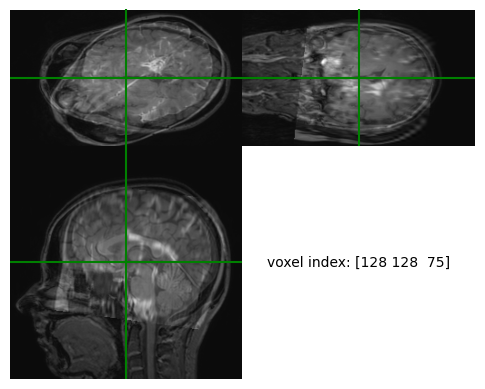

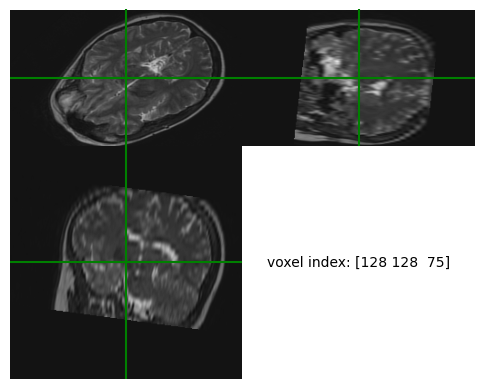

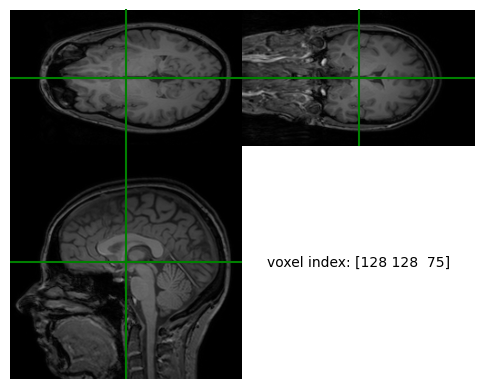

In [5]:
Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() )
Viewer( T2_data_resampled / T2_data_resampled.max() )
Viewer( T1_data / T1_data.max() )

### Task 2: Compute and visualize the joint histogram

Compute the joint histogram 
$$ 
\mathbf{H} = 
\begin{pmatrix}
h_{1,1} & ... & h_{1,B} \\
\vdots & ... & \vdots \\
h_{B,1} & ... & h_{B,B} \\
\end{pmatrix} 
$$
of the T1-weighted scan and the resampled T2-weighted scan you just created, using $B=32$ bins. In order not to let the registration process be dominated by the (extremely numerous) background voxels, ignore all voxels with an intensity lower than 10 in either image when computing the histogram. Visualize the joint histogram using a 3D bar plot, and label the axes.

> ***Hints:***
>
> - To compute a 2D histogram, you can use the function
>
>           np.histogram2d(x,y,bins,range)
> 
> - A 3D bar plot can be created as follows:
>
>           fig, ax = plt.subplots( subplot_kw=dict( projection='3d') )
>           plt.bar3d(xpos, ypos, zpos, dx, dy, dz)
>
>   where xpos, ypos, and zpos are the anchor points of the bars and dx, dy, and dz are the dimensions of the bars.
>
> - A useful "trick" to verify that your axes are labeled correctly, is to use a different number of bins for the two scans.
>

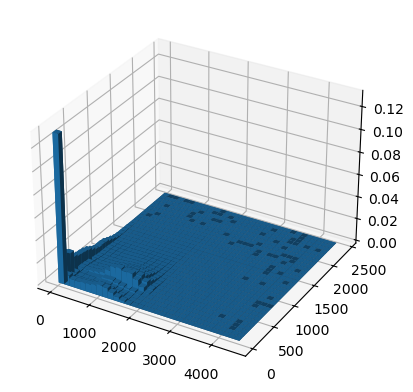

In [6]:
# Filter 
mask = (T1_data >= 10) & (T2_data_resampled >= 10)
T1_filtered = T1_data[mask]
T2_filtered = T2_data_resampled[mask]

# 2D histogram
B = 32
H, xedges, yedges = np.histogram2d(T1_filtered.ravel(), T2_filtered.ravel(), bins=B)

fig, ax = plt.subplots( subplot_kw=dict( projection='3d') )
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)  # bars start at z=0

# Size 
dx = (xedges[1] - xedges[0])  # Width
dy = (yedges[1] - yedges[0]) 
dz = H.ravel()/np.sum(H)   
ax.bar3d(xpos, ypos, zpos, dx, dy, dz)

### Task 3: Compute the mutual information between the two images
Write a function that takes two image volumes defined on the same image grid as input, and returns the mutual information between the two images:

$$ 
MI = H_{F} + H_{M} - H_{F,M} 
$$
with
$$ 
H_{F,M} = - \sum_{f=1}^{B} \sum_{m=1}^{B} p_{f,m} \log(p_{f,m}),
$$
$$ 
H_{F} = - \sum_{f=1}^{B} p_{f} \log(p_{f}), 
$$
and
$$
H_{M} = - \sum_{m=1}^{B} p_{m} \log(p_{m})
.
$$

Your function should make use of the joint histogram computed as in the previous task (i.e., using $B=32$ bins and ignoring all voxels with intensity lower than 10).

Use your new function to compute the mutual information between the T1-weighted image and the resampled T2-weighted image.

> ***Hints:***
>
> - To avoid numerical errors when one of the bins is empty and 0*log(0)=0 is therefore computed numerically, you can add a tiny value (e.g., 1e-12) to each histogram bin

In [7]:
def compute_mutual_information(T1, T2, bins=32, intensity_threshold=10):
    # Filter out voxels with intensity lower than the threshold in either image
    mask = (T1 >= intensity_threshold) & (T2 >= intensity_threshold)
    T1_filtered = T1[mask]
    T2_filtered = T2[mask]

    # Compute the 2D histogram
    hist, xedges, yedges = np.histogram2d(T1_filtered.ravel(), T2_filtered.ravel(), bins=bins)

    # Normalize the joint histogram to get joint probability distribution
    p_fm = hist / np.sum(hist)

    # Compute marginal histograms
    p_f = np.sum(p_fm, axis=1)
    p_m = np.sum(p_fm, axis=0)

    # Add a tiny value to avoid log(0)
    p_fm += 1e-12
    p_f += 1e-12
    p_m += 1e-12

    # Compute entropies
    H_FM = -np.sum(p_fm * np.log(p_fm))
    H_F = -np.sum(p_f * np.log(p_f))
    H_M = -np.sum(p_m * np.log(p_m))

    # Compute mutual information
    MI = H_F + H_M - H_FM

    return MI

mutual_information = compute_mutual_information(T1_data, T2_data_resampled)
print("Mutual Information:", mutual_information)

Mutual Information: 0.11674744070423237


### Task 4: Evaluate the mutual information across a range of rotation angles

Implement a grid search over a range of rotation angles, with the goal of identifying the angle with approximately the highest mutual information (i.e., where the registration is best). Make an educated guess of a suitable range by visually inspecting the images (or by simply trying a few rotation angles and inspecting the result), and then define a list of candidate angles at intervals of e.g., 5° apart:

       a = np.arange(a_{lowest}, a_{highest}, 5)

Loop over all candidate rotation angles, each time (1) creating a corresponding rotation matrix $\mathbf{R}$; (2) resampling the T2-weighted volume accordingly; (3) calculating the mutual information with the function you created above; and (4) storing the mutual information value.

> ***Hint:***
> 
> - A 3D rotation matrix can be parameterized as follows:
> 
> $$\mathbf{R} = \mathbf{R}_{z} \mathbf{R}_{y} \mathbf{R_{x}},$$ 
>where
>
>$$
\mathbf{R}_z =
\begin{pmatrix}
\cos(\theta_z) & -\sin(\theta_z) & 0 \\
\sin(\theta_z) & \cos(\theta_z) & 0 \\
0 & 0 & 1
\end{pmatrix}
>$$
>
>implements a rotation around the z-axis in world coordinates,
>
>$$
>\mathbf{R}_y =
>\begin{pmatrix}
>\cos(\theta_y) & 0 & \sin(\theta_y) \\
>0 & 1 & 0 \\
>-\sin(\theta_y) & 0 & \cos(\theta_y)
>\end{pmatrix}
>$$
>
>is a rotation around the y-axis, and
>
>$$
>\mathbf{R}_x =
>\begin{pmatrix}
>1 & 0 & 0 \\
>0 & \cos(\theta_x) & -\sin(\theta_x) \\
>0 & \sin(\theta_x) & \cos(\theta_x)
>\end{pmatrix}
>$$
>
>rotates around the x-axis.
>
>
> - If you didn't figure out in Task 1 which axis the T2-weighted volume was rotated around, you can try rotating around each axis (one at a time) to see the effect of each transformation. Once you've determined the correct rotation axis, the rotation angles around the other axes should be clamped to zero.


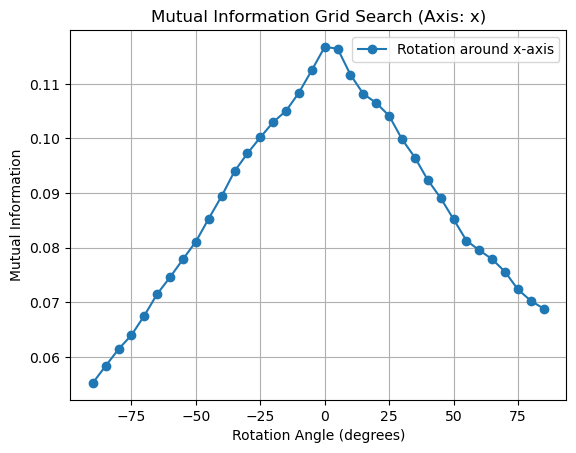

Best angle for x-axis: 0 degrees with MI: 0.11674744070423237


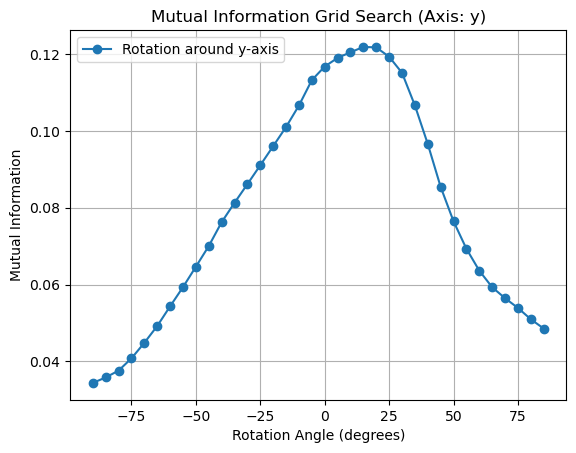

Best angle for y-axis: 15 degrees with MI: 0.12184445621879902


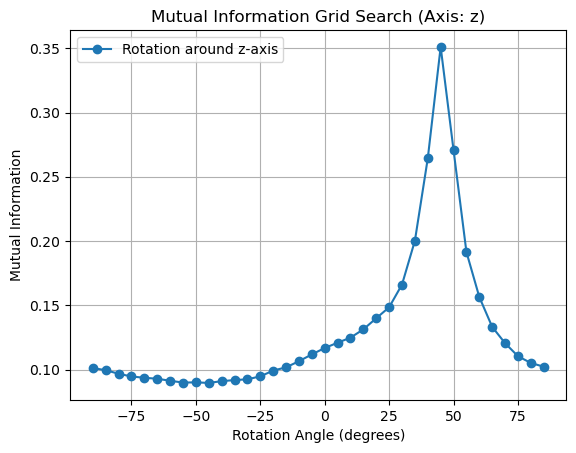

Best angle for z-axis: 45 degrees with MI: 0.3510390673649333
Displaying the registered T2 and T1 images:


/var/folders/r3/8xpsf3xj17q9q8clx4xqpngr0000gn/T/ipykernel_70306/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


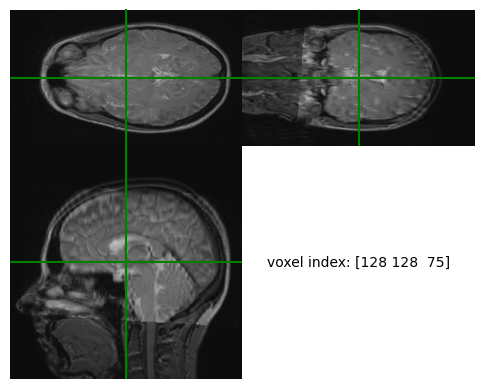

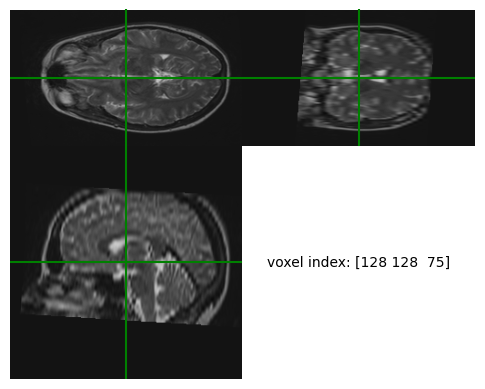

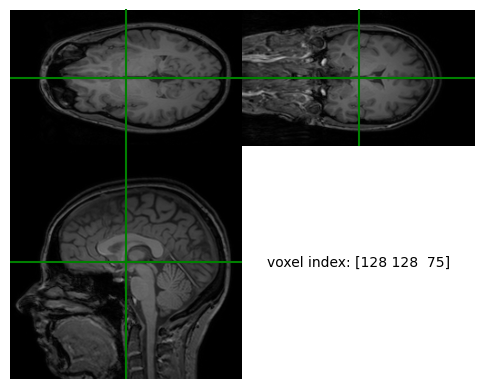

In [8]:
from scipy.ndimage import map_coordinates

# rotation matrix function
def get_rotation_matrix(angle, axis):
    angle = np.deg2rad(angle)  # Convert to radians
    if axis == 'x':
        return np.array([[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]])
    elif axis == 'y':
        return np.array([[np.cos(angle), 0, np.sin(angle)], [0, 1, 0], [-np.sin(angle), 0, np.cos(angle)]])
    elif axis == 'z':
        return np.array([[np.cos(angle), -np.sin(angle), 0], [np.sin(angle), np.cos(angle), 0], [0, 0, 1]])

# Grid search for mutual information over rotation angles
def grid_search_mi(T1_data, T2_data, M_T1, M_T2, V1, V2, V3, axis, a_lower=-90, a_upper=90, step=5):
    a = np.arange(a_lower, a_upper, step)  # Array of angles to test
    E_w = np.zeros(len(a))  # Array to store mutual information values
    V_T1 = np.array([V1.ravel(), V2.ravel(), V3.ravel(), np.ones(V1.size)])  
    compute_vox_to_world = M_T1 @ V_T1
    
    for ind in range(len(a)):
        R = get_rotation_matrix(a[ind], axis)  # Get rotation matrix for the angle and axis
        compute_rotated_world = R @ compute_vox_to_world[:3, :]
        compute_rotated_to_vox = np.linalg.inv(M_T2) @ np.vstack((compute_rotated_world, np.ones((1, V1.size))))
        T2_rotated = map_coordinates(T2_data, compute_rotated_to_vox[:3], order=3).reshape(T1_data.shape)
        E_w[ind] = compute_mutual_information(T1_data, T2_rotated)
    
    return a, E_w

# Plot MI results for each axis and determine the best angle
def plot_and_find_best_angles(T1_data, T2_data, M_T1, M_T2, V1, V2, V3):
    best_angles = {}
    for axis in ['x', 'y', 'z']:
        a, E_w = grid_search_mi(T1_data, T2_data, M_T1, M_T2, V1, V2, V3, axis)
        best_angle = a[np.argmax(E_w)]
        best_angles[axis] = best_angle
        # Plot MI values for axis
        plt.figure()
        plt.plot(a, E_w, 'o-', label=f'Rotation around {axis}-axis')
        plt.title(f'Mutual Information Grid Search (Axis: {axis})')
        plt.xlabel('Rotation Angle (degrees)')
        plt.ylabel('Mutual Information')
        plt.legend()
        plt.grid()
        plt.show()
        print(f"Best angle for {axis}-axis: {best_angle} degrees with MI: {E_w[np.argmax(E_w)]}")
    
    return best_angles

# Visualize the registered result for the best z-axis angle
def rotate_and_display_best_image(T1_data, T2_data, M_T1, M_T2, V1, V2, V3, best_angle, axis='z'):
    R = get_rotation_matrix(best_angle, axis)
    V_T1 = np.array([V1.ravel(), V2.ravel(), V3.ravel(), np.ones(V1.size)])  
    compute_vox_to_world = M_T1 @ V_T1
    compute_rotated_world = R @ compute_vox_to_world[:3, :]
    compute_rotated_to_vox = np.linalg.inv(M_T2) @ np.vstack((compute_rotated_world, np.ones((1, V1.size))))
    T2_rotated = map_coordinates(T2_data, compute_rotated_to_vox[:3], order=3).reshape(T1_data.shape)
    
    print("Displaying the registered T2 and T1 images:")
    Viewer(T2_rotated / T2_rotated.max() + T1_data / T1_data.max())  # Overlay T1 and rotated T2
    Viewer(T2_rotated / T2_rotated.max())  # Rotated T2 alone
    Viewer(T1_data / T1_data.max())        # T1 alone


best_angles = plot_and_find_best_angles(T1_data, T2_data, M_T1, M_T2, V1, V2, V3)

rotate_and_display_best_image(T1_data, T2_data, M_T1, M_T2, V1, V2, V3, best_angles['z'], axis='z')

### Task 5: Perform automatic registration

Plot the negative mutual information, i.e. the energy function $E(\mathbf{w})= H_{F,M}-H_{F}-H_{M}$ for every angle in your grid search space. Select the one with the lowest energy (i.e., the best angle for registration) and transform the T2-weighted volume according to this angle.

Use the Viewer() function to visualize your registration result.

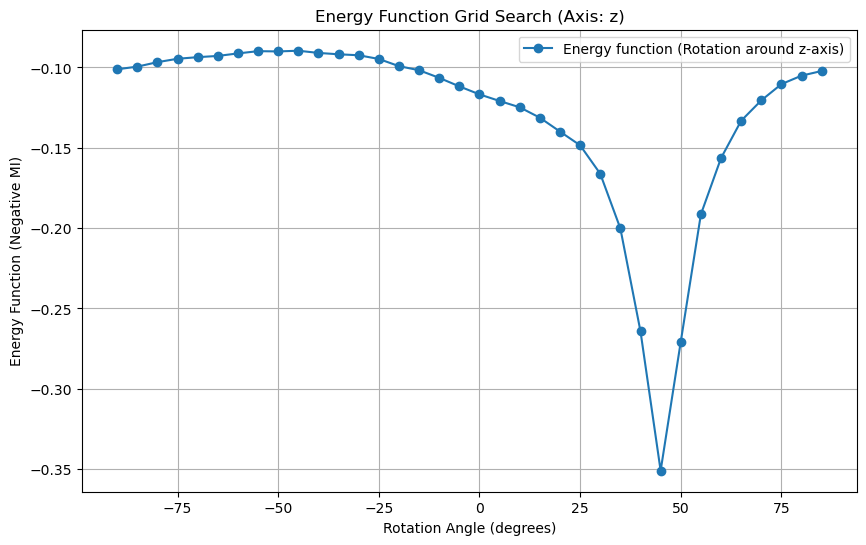

Best angle for z-axis: 45 degrees with lowest energy: -0.35103906736493284
Displaying the registered T2 and T1 images:


/var/folders/r3/8xpsf3xj17q9q8clx4xqpngr0000gn/T/ipykernel_70306/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


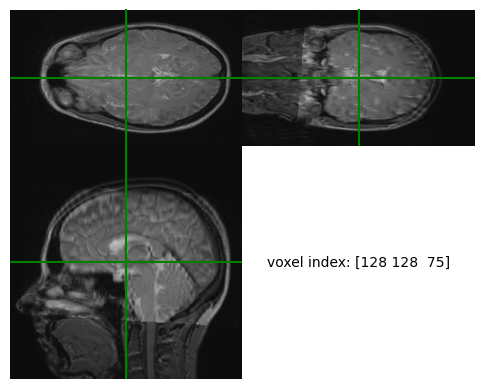

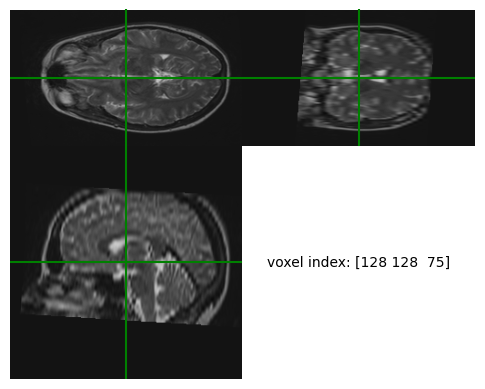

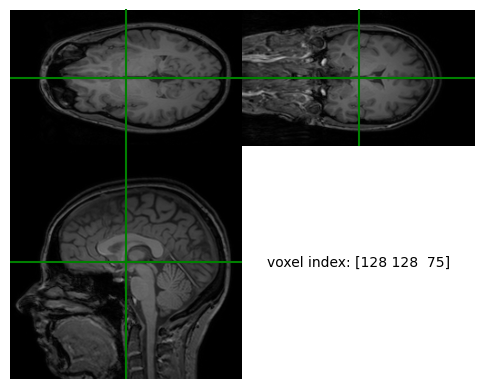

In [9]:
def compute_energy_function(T1, T2, bins=32, intensity_threshold=10):
    # the same as mutual information but with negative sign
    mask = (T1 >= intensity_threshold) & (T2 >= intensity_threshold)
    T1_filtered = T1[mask]
    T2_filtered = T2[mask]

    hist, xedges, yedges = np.histogram2d(T1_filtered.ravel(), T2_filtered.ravel(), bins=bins)
    hist = hist / np.sum(hist)  # Normalize the histogram to get probabilities

    # marginal probabilities
    p_f = np.sum(hist, axis=1)
    p_m = np.sum(hist, axis=0)

    hist += 1e-12
    p_f += 1e-12
    p_m += 1e-12

    # entropies
    H_fm = -np.sum(hist * np.log(hist))
    H_f = -np.sum(p_f * np.log(p_f))
    H_m = -np.sum(p_m * np.log(p_m))

    # Energy function (negative mutual information)
    energy = H_fm - H_f - H_m
    return energy

# Again grid search but for the energy function (negative mutual information)
def grid_search_energy(T1_data, T2_data, M_T1, M_T2, V1, V2, V3, axis, a_lower=-90, a_upper=90, step=5):
    a = np.arange(a_lower, a_upper, step)
    E_w = np.zeros(len(a))  # Array to store energy function values (negative mutual information)
    
    # Convert voxel coordinates to world coordinates
    V_T1 = np.array([V1.ravel(), V2.ravel(), V3.ravel(), np.ones(V1.size)])  
    compute_vox_to_world = M_T1 @ V_T1
    
    # Loop over each angle and compute the energy function
    for ind, angle in enumerate(a):
        R = get_rotation_matrix(angle, axis)
        compute_rotated_world = R @ compute_vox_to_world[:3, :]
        compute_rotated_to_vox = np.linalg.inv(M_T2) @ np.vstack((compute_rotated_world, np.ones((1, V1.size))))
        T2_rotated = map_coordinates(T2_data, compute_rotated_to_vox[:3], order=3).reshape(T1_data.shape)
        
        E_w[ind] = compute_energy_function(T1_data, T2_rotated)
    
    return a, E_w

# Plot the energy function and find the best angle
def plot_energy_results(a, E_w, axis):
    plt.figure(figsize=(10, 6))
    plt.plot(a, E_w, 'o-', label=f'Energy function (Rotation around {axis}-axis)')
    plt.title(f'Energy Function Grid Search (Axis: {axis})')
    plt.xlabel('Rotation Angle (degrees)')
    plt.ylabel('Energy Function (Negative MI)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    best_angle = a[np.argmin(E_w)]
    print(f"Best angle for {axis}-axis: {best_angle} degrees with lowest energy: {E_w.min()}")
    
    return best_angle


a_z, E_w_z = grid_search_energy(T1_data, T2_data, M_T1, M_T2, V1, V2, V3, axis='z')

best_angle_z = plot_energy_results(a_z, E_w_z, 'z')

rotate_and_display_best_image(T1_data, T2_data, M_T1, M_T2, V1, V2, V3, best_angle_z, axis='z')

### Task 6: Compare the joint histogram before and after registration

Visualize the joint histogram after registration. Compare the result to your initial joint histogram (i.e., before registration) and discuss your findings in your report.

Joint Histogram Before Registration


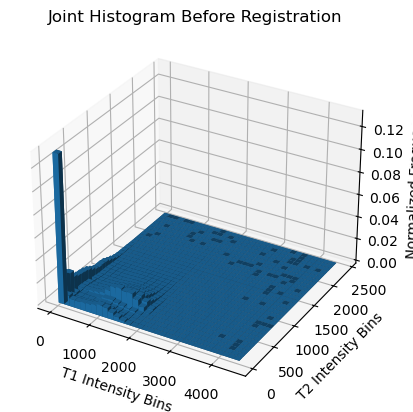

Joint Histogram After Registration


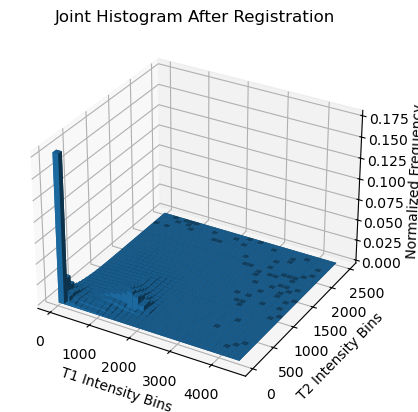

In [11]:
# Function to compute and plot the joint histogram
def compute_and_plot_joint_histogram(T1, T2, title="Joint Histogram"):
    """
    Computes and plots the joint histogram for two 3D images.
    """
    # Filter out low-intensity voxels
    mask = (T1 >= 10) & (T2 >= 10)
    T1_filtered = T1[mask]
    T2_filtered = T2[mask]

    # Compute the 2D histogram
    B = 32  # Number of bins
    H, xedges, yedges = np.histogram2d(T1_filtered.ravel(), T2_filtered.ravel(), bins=B)

    # Plot the 3D bar plot of the histogram
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)  # Start bars at z=0

    dx = (xedges[1] - xedges[0])  # Width of each bar
    dy = (yedges[1] - yedges[0]) 
    dz = H.ravel() / np.sum(H)  # Normalize histogram

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz)
    ax.set_xlabel("T1 Intensity Bins")
    ax.set_ylabel("T2 Intensity Bins")
    ax.set_zlabel("Normalized Frequency")
    ax.set_title(title)
    plt.show()

# initial joint histogram (before registration)
print("Joint Histogram Before Registration")
compute_and_plot_joint_histogram(T1_data, T2_data_resampled, title="Joint Histogram Before Registration")

# Rotate T2 using best_angle_z and compute joint histogram after registration
# Define rotation and resampling
def rotate_T2_with_best_angle(T2_data, M_T1, M_T2, V1, V2, V3, best_angle, axis='z'):
    R = get_rotation_matrix(best_angle, axis)
    V_T1 = np.array([V1.ravel(), V2.ravel(), V3.ravel(), np.ones(V1.size)])
    compute_vox_to_world = M_T1 @ V_T1
    compute_rotated_world = R @ compute_vox_to_world[:3, :]
    compute_rotated_to_vox = np.linalg.inv(M_T2) @ np.vstack((compute_rotated_world, np.ones((1, V1.size))))
    
    # Interpolate 
    T2_rotated = map_coordinates(T2_data, compute_rotated_to_vox[:3], order=3).reshape(T1_data.shape)
    return T2_rotated

# Rotate T2_data with the best angle found from Task 5
T2_rotated = rotate_T2_with_best_angle(T2_data, M_T1, M_T2, V1, V2, V3, best_angle_z, axis='z')

# Display the joint histogram after registration
print("Joint Histogram After Registration")
compute_and_plot_joint_histogram(T1_data, T2_rotated, title="Joint Histogram After Registration")

### Additional task for the enthusiastic student: Compare the MI obtained with landmark-based and intensity-based registration

Perform landmark-based registration between the T1-weighted and T2-weighted volumes instead, just like you did in the last exercise. For the resulting registration, view your results with the Viewer() class; visualize the joint histogram, and calculate the mutual information. 

Compare the results with those obtained using mutual information, and discuss.

> ***Hint:***
> - You can reuse the landmarks that you collected in the landmark-based registration exercise, as these were defined in voxel space. 

### Conclusion

In this exercise, we successfully implemented mutual information-based registration to align T1-weighted and T2-weighted MRI images, overcoming challenges posed by differing intensity distributions. By optimizing mutual information (MI), we enhanced the anatomical alignment of the two images, even when intensity features varied between imaging modalities. However, we changed the rotation matrixes provided as hint because they were not leading to a correct answer

Using a **joint histogram**:

$$
H = \begin{pmatrix}
h_{1,1} & \cdots & h_{1,B} \\
\vdots & \ddots & \vdots \\
h_{B,1} & \cdots & h_{B,B} \\
\end{pmatrix}
$$

we could quantify shared intensity information and apply this metric across a range of rotation angles. Through grid search, we determined the optimal transformation for alignment by maximizing MI. Additionally, the **energy function**:

$$
E(\mathbf{w}) = H_{F,M} - H_{F} - H_{M}
$$

provided an effective means to automatically select the best alignment parameters, minimizing $ E(\mathbf{w}) $ to refine image overlap.

Comparing the joint histograms before and after registration confirmed the effectiveness of our alignment approach. The histogram post-registration showed increased alignment of intensity pairs, indicating that MI-based registration achieved substantial image alignment, capturing critical anatomical correspondences between T1 and T2 images. This exercise demonstrates the robustness and versatility of mutual information as a registration tool, capable of supporting fully automated multimodal alignment tasks.